In [1]:
!ls /kaggle/input/dataset/dataset

data.csv  Kenzie  Rayvel  Valentino


In [2]:
!pip install mtcnn grad-cam lz4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

In [3]:
!pip install --force-reinstall numpy==1.26.4 scipy==1.12.0 tensorflow==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 40.0 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 55.2 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 48.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 86.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 91.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [4]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import RandomRotation, RandomZoom
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from mtcnn import MTCNN

import warnings
warnings.filterwarnings('ignore')

In [5]:
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

DATA_DIR = "/kaggle/input/dataset/dataset"
CSV_PATH  = os.path.join(DATA_DIR, "data.csv")

IMG_SIZE   = 224
BATCH_SIZE = 16
VAL_SPLIT  = 0.2

USE_FACE_DET = True

# tf.data.experimental.enable_debug_mode()

In [6]:
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=['id','label'])
df['label'] = df['label'].astype(str).str.strip()
df['id']    = df['id'].astype(str).str.strip()

In [7]:
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

DATA_DIR = "/kaggle/input/dataset/dataset"
CSV_PATH  = os.path.join(DATA_DIR, "data.csv")

IMG_SIZE   = 224
BATCH_SIZE = 16
VAL_SPLIT  = 0.2

USE_FACE_DET = True

# tf.data.experimental.enable_debug_mode()

In [8]:
# Case-insensitive map
list_dirs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
folder_map = {d.lower(): d for d in list_dirs}

def canonicalize(lbl):
    key = lbl.lower()
    if key in folder_map:
        return folder_map[key]
    raise ValueError(
        f"CSV label '{lbl}' has no matching folder in {DATA_DIR}. "
        f"Available: {list_dirs}"
    )

In [9]:
print(list_dirs)
print(folder_map)

['Rayvel', 'Valentino', 'Kenzie']
{'rayvel': 'Rayvel', 'valentino': 'Valentino', 'kenzie': 'Kenzie'}


In [10]:
df['label_canon'] = df['label'].apply(canonicalize)

df['path'] = df.apply(lambda r: os.path.join(DATA_DIR, r['label_canon'], r['id']), axis=1)

# CLASSES dari canonical labels and map ke int y
CLASSES = sorted(df['label_canon'].unique().tolist())
label_to_idx = {c: i for i, c in enumerate(CLASSES)}
df['y'] = df['label_canon'].map(label_to_idx).astype(np.int32)

print(df['label_canon'])
print("CLASSES (softmax order):", CLASSES)
print("Counts per class:\n", df['label_canon'].value_counts())

0      Valentino
1      Valentino
2      Valentino
3      Valentino
4      Valentino
         ...    
247       Rayvel
248       Rayvel
249       Rayvel
250       Rayvel
251       Rayvel
Name: label_canon, Length: 252, dtype: object
CLASSES (softmax order): ['Kenzie', 'Rayvel', 'Valentino']
Counts per class:
 label_canon
Valentino    84
Kenzie       84
Rayvel       84
Name: count, dtype: int64


In [11]:
# Stratified split: train / val / test
TEST_SPLIT = 0.15
VAL_SPLIT  = 0.15

paths = df['path'].values
ys    = df['y'].values

from sklearn.model_selection import StratifiedShuffleSplit
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SPLIT, random_state=SEED)
trainval_idx, test_idx = next(sss1.split(paths, ys))

paths_trainval, paths_test = paths[trainval_idx], paths[test_idx]
ys_trainval,   ys_test    = ys[trainval_idx], ys[test_idx]

val_rel = VAL_SPLIT / (1.0 - TEST_SPLIT)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_rel, random_state=SEED)
train_idx, val_idx = next(sss2.split(paths_trainval, ys_trainval))

train_paths, val_paths = paths_trainval[train_idx], paths_trainval[val_idx]
train_ys,    val_ys    = ys_trainval[train_idx],   ys_trainval[val_idx]

print("Sizes -> train/val/test:", len(train_paths), len(val_paths), len(paths_test))

Sizes -> train/val/test: 176 38 38


In [12]:
detector = MTCNN() if USE_FACE_DET else None

def crop_face_mtcnn(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    if detector is not None:
        dets = detector.detect_faces(img_rgb)
        if dets:
            det = max(dets, key=lambda d: d['box'][2]*d['box'][3])
            x,y,w,h = det['box']
            x, y = max(0,x), max(0,y)
            face = img_rgb[y:y+h, x:x+w]
            if face.size != 0:
                return face
    # fallback
    h,w,_ = img_rgb.shape
    side = min(h,w)
    y0 = (h-side)//2; x0 = (w-side)//2
    return img_rgb[y0:y0+side, x0:x0+side]

In [13]:
AUTO = tf.data.AUTOTUNE

def load_and_preprocess(path, label):
    path = tf.strings.reduce_join(path)
    path = path.numpy().decode()

    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"imread failed: {path}")

    if USE_FACE_DET:
        rgb = crop_face_mtcnn(bgr)
        if rgb is None or rgb.size == 0:
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    else:
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # Resize to VGG input size
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    return rgb.astype(np.float32), label

In [14]:
def tf_load_and_preprocess(path, label):
    rgb, label = tf.numpy_function(load_and_preprocess, [path, label], [tf.float32, tf.int32])
    rgb.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label.set_shape([])
    return rgb, label

rotation_layer = tf.keras.layers.RandomRotation(factor=0.2)
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.1)
def augment(rgb, label):
  rgb = tf.image.random_brightness(rgb, 0.15)
  rgb = tf.image.random_contrast(rgb, 0.85, 1.15)
  rgb = tf.image.random_flip_left_right(rgb)
    
  rgb = tf.image.random_flip_up_down(rgb)  # Flip top-bottom
  rgb = rotation_layer(rgb)  # Rotation
  rgb = zoom_layer(rgb)  # Zoom

  crop_size = tf.random.uniform([], int(IMG_SIZE*0.85), IMG_SIZE, dtype=tf.int32)
  rgb = tf.image.resize_with_crop_or_pad(rgb, IMG_SIZE, IMG_SIZE)
  rgb = tf.image.random_crop(rgb, size=[crop_size, crop_size, 3])
  rgb = tf.image.resize(rgb, [IMG_SIZE, IMG_SIZE])
  return rgb, label

def to_vgg_input(rgb, label):
    x = vgg16.preprocess_input(rgb)  # harusnya isinya float RGB antara [0..255]
    return x, label

In [15]:
train_ds = (tf.data.Dataset
            .from_tensor_slices((train_paths, train_ys))
            .shuffle(1024, seed=SEED)
            .map(tf_load_and_preprocess, num_parallel_calls=AUTO)
            .map(augment, num_parallel_calls=AUTO)
            .map(to_vgg_input, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

val_ds = (tf.data.Dataset
          .from_tensor_slices((val_paths, val_ys))
          .map(tf_load_and_preprocess, num_parallel_calls=AUTO)
          .map(to_vgg_input, num_parallel_calls=AUTO)
          .batch(BATCH_SIZE)
          .prefetch(AUTO))

test_ds = (tf.data.Dataset
           .from_tensor_slices((paths_test, ys_test))
           .map(tf_load_and_preprocess, num_parallel_calls=AUTO)
           .map(to_vgg_input, num_parallel_calls=AUTO)
           .batch(BATCH_SIZE)
           .prefetch(AUTO))

print("train/val/test sizes:", len(train_paths), len(val_paths), len(paths_test))

train/val/test sizes: 176 38 38


In [16]:
from tensorflow.keras import regularizers

In [17]:
NUM_CLASSES = len(CLASSES)

base = vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False
    
print("Status 'trainable' untuk setiap layer di base model:")
for layer in base.layers:
    print(f"{layer.name}: {layer.trainable}")

def build_head(x, dropout=0.5): 
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x) # -> tambahin ini, kurangin dense
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return out

inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inp, training=False)
out = build_head(x, dropout=0.5)
model_A = models.Model(inp, out, name="VGG16_feature_extraction")

model_A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_A.summary()
print("Classes order:", CLASSES)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Status 'trainable' untuk setiap layer di base model:
input_layer: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: False
block5_pool: False


Model: "VGG16_feature_extraction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,859 (56.65 MB)

 Trainable params: 133,635 (522.01 KB)

 Non-trainable params: 14,716,224 (56.14 MB)

Classes order: ['Kenzie', 'Rayvel', 'Valentino']


In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ModelCheckpoint("vgg_FE_best.keras", save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)
]

hist_A = model_A.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)
model_A.save("/kaggle/working/export_vgg_face_A.keras")

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1730s 156s/step - accuracy: 0.3750 - loss: 1.8447 - val_accuracy: 0.3421 - val_loss: 1.5846 - learning_rate: 3.0000e-04
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1732s 155s/step - accuracy: 0.4886 - loss: 1.4840 - val_accuracy: 0.4211 - val_loss: 1.1812 - learning_rate: 3.0000e-04
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1715s 153s/step - accuracy: 0.5170 - loss: 1.2606 - val_accuracy: 0.6053 - val_loss: 0.9362 - learning_rate: 3.0000e-04
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1722s 156s/step - accuracy: 0.6080 - loss: 0.9441 - val_accuracy: 0.7632 - val_loss: 0.7388 - learning_rate: 3.0000e-04
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1723s 154s/step - accuracy: 0.6364 - loss: 0.9291 - val_accuracy: 0.8158 - val_loss: 0.6036 - learning_rate: 3.0000e-04
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1712s 155s/step - accuracy: 0.7159 - loss: 0.7034 - val_accuracy: 0.8158 - val_loss: 0.5203 - learning_rate: 3.0000e-04
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1716s 157s/ste

In [19]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras import layers, models

NUM_CLASSES = len(CLASSES)

ft_base = vgg16.VGG16(include_top=False, weights='imagenet',
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in ft_base.layers:
    layer.trainable = ("block5" in layer.name)

def build_head_ft(x, dropout=0.5):
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return out

inp_ft = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x_ft = ft_base(inp_ft, training=True)  # enable gradients to flow in unfrozen block5
out_ft = build_head_ft(x_ft, dropout=0.5)
model_B = models.Model(inp_ft, out_ft, name="VGG16_finetune_block5")

model_B.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_B.summary()

Model: "VGG16_finetune_block5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,859 (56.65 MB)

 Trainable params: 7,213,059 (27.52 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

In [20]:
cb_B = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ModelCheckpoint("vgg_FT_best.keras", save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-7, monitor='val_accuracy'),
]

hist_B = model_B.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb_B
)

model_B.save("/kaggle/working/export_vgg_face_B.keras")

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1719s 151s/step - accuracy: 0.5909 - loss: 1.0913 - val_accuracy: 0.3947 - val_loss: 6.2511 - learning_rate: 3.0000e-04
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1705s 154s/step - accuracy: 0.7898 - loss: 0.5909 - val_accuracy: 1.0000 - val_loss: 0.0236 - learning_rate: 3.0000e-04
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1696s 154s/step - accuracy: 0.8864 - loss: 0.3082 - val_accuracy: 0.8947 - val_loss: 0.2871 - learning_rate: 3.0000e-04
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1717s 155s/step - accuracy: 0.8864 - loss: 0.3377 - val_accuracy: 0.6316 - val_loss: 2.9444 - learning_rate: 3.0000e-04
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1748s 155s/step - accuracy: 0.9432 - loss: 0.1536 - val_accuracy: 0.8158 - val_loss: 0.4081 - learning_rate: 3.0000e-04
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1732s 156s/step - accuracy: 0.9773 - loss: 0.1073 - val_accuracy: 1.0000 - val_loss: 0.0183 - learning_rate: 1.5000e-04
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1703s 151s/ste

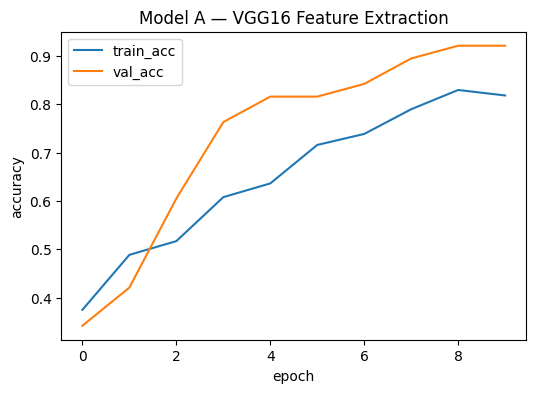

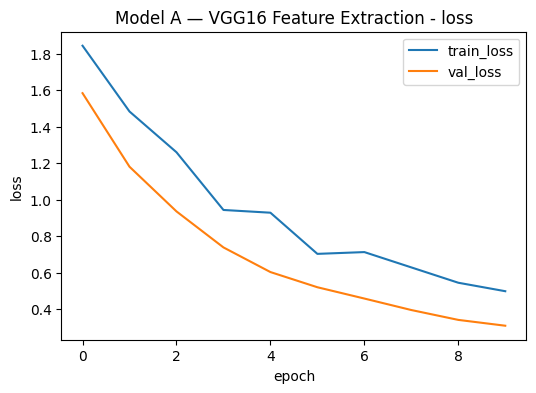

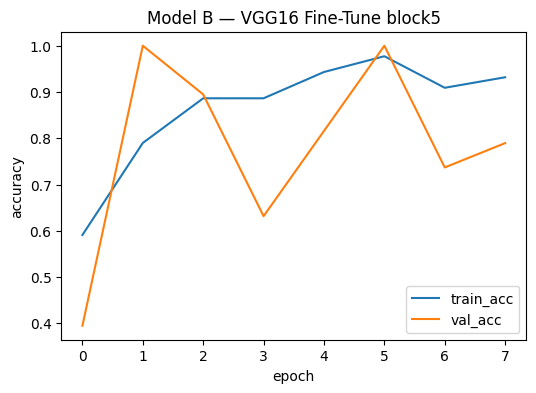

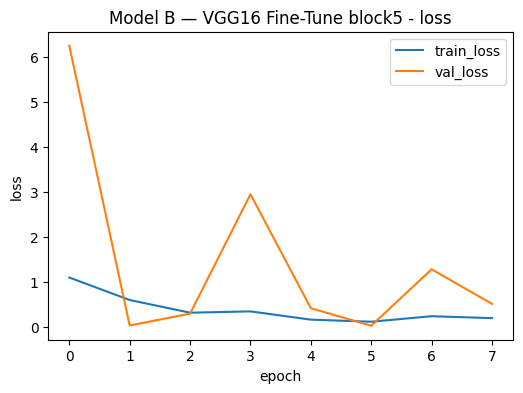

In [21]:
import matplotlib.pyplot as plt

def plot_history(h, title):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(h.history['accuracy'], label='train_acc')
    ax.plot(h.history['val_accuracy'], label='val_acc')
    ax.set_title(title); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy'); ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(h.history['loss'], label='train_loss')
    ax.plot(h.history['val_loss'], label='val_loss')
    ax.set_title(title + " - loss"); ax.set_xlabel('epoch'); ax.set_ylabel('loss'); ax.legend()
    plt.show()

plot_history(hist_A, "Model A — VGG16 Feature Extraction")
plot_history(hist_B, "Model B — VGG16 Fine-Tune block5")

== Validation results ==
Model A (val) — classification report:
              precision    recall  f1-score   support

      Kenzie     0.9286    1.0000    0.9630        13
      Rayvel     1.0000    0.7692    0.8696        13
   Valentino     0.8571    1.0000    0.9231        12

    accuracy                         0.9211        38
   macro avg     0.9286    0.9231    0.9185        38
weighted avg     0.9305    0.9211    0.9184        38



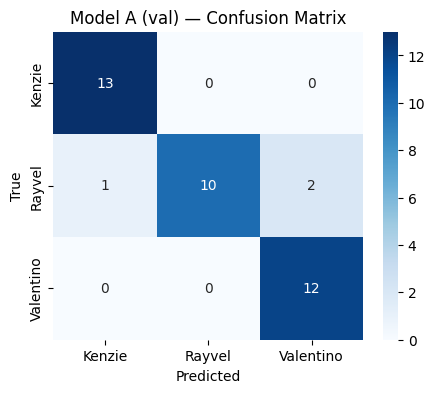

Model B (val) — classification report:
              precision    recall  f1-score   support

      Kenzie     1.0000    1.0000    1.0000        13
      Rayvel     1.0000    1.0000    1.0000        13
   Valentino     1.0000    1.0000    1.0000        12

    accuracy                         1.0000        38
   macro avg     1.0000    1.0000    1.0000        38
weighted avg     1.0000    1.0000    1.0000        38



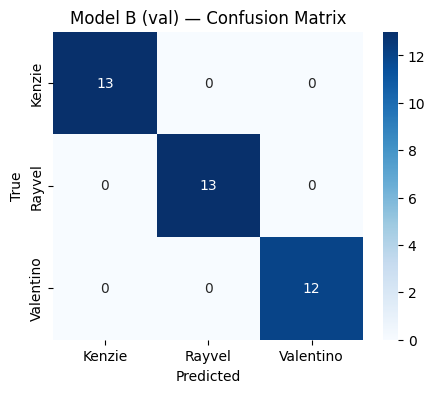

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def eval_on_ds(model, ds, y_true, title):
    y_pred = []
    for xb, _ in ds:
        probs = model.predict(xb, verbose=0)
        y_pred.append(np.argmax(probs, axis=1))
    y_pred = np.concatenate(y_pred)
    print(f"{title} — classification report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title + " — Confusion Matrix")
    plt.show()
    return y_pred

# val_ys is the ground-truth order used to build val_ds (no shuffle)
print("== Validation results ==")
_ = eval_on_ds(model_A, val_ds, val_ys, "Model A (val)")
_ = eval_on_ds(model_B, val_ds, val_ys, "Model B (val)")

In [23]:
test_ys = []
for _, label in test_ds:
    test_ys.append(label)  

test_ys = np.concatenate(test_ys, axis=0)

print("== Test results (aggregate metrics) ==")
test_loss_A, test_acc_A = model_A.evaluate(test_ds, verbose=0)
test_loss_B, test_acc_B = model_B.evaluate(test_ds, verbose=0)
print(f"Model A — TEST: loss={test_loss_A:.4f}, acc={test_acc_A:.4f}")
print(f"Model B — TEST: loss={test_loss_B:.4f}, acc={test_acc_B:.4f}")

== Test results (aggregate metrics) ==
Model A — TEST: loss=0.3230, acc=0.9737
Model B — TEST: loss=0.0065, acc=1.0000



== Test results (detailed) ==
Model A (test) — classification report:
              precision    recall  f1-score   support

      Kenzie     0.9231    1.0000    0.9600        12
      Rayvel     1.0000    0.9231    0.9600        13
   Valentino     1.0000    1.0000    1.0000        13

    accuracy                         0.9737        38
   macro avg     0.9744    0.9744    0.9733        38
weighted avg     0.9757    0.9737    0.9737        38



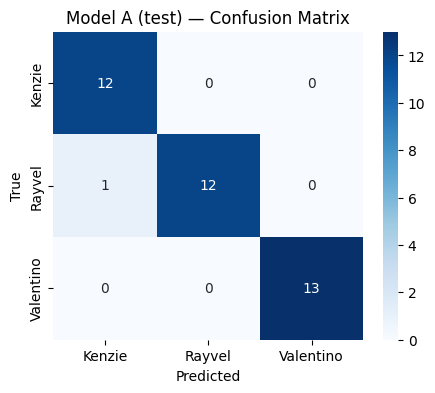

Model B (test) — classification report:
              precision    recall  f1-score   support

      Kenzie     1.0000    1.0000    1.0000        12
      Rayvel     1.0000    1.0000    1.0000        13
   Valentino     1.0000    1.0000    1.0000        13

    accuracy                         1.0000        38
   macro avg     1.0000    1.0000    1.0000        38
weighted avg     1.0000    1.0000    1.0000        38



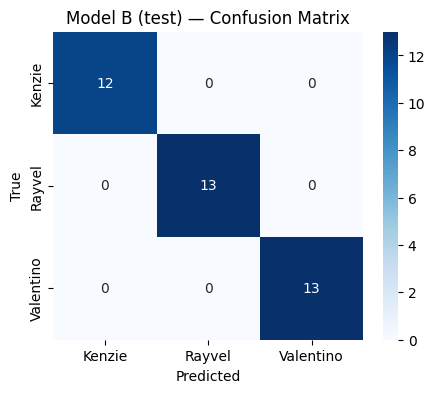

In [24]:
print("\n== Test results (detailed) ==")
_ = eval_on_ds(model_A, test_ds, test_ys, "Model A (test)")
_ = eval_on_ds(model_B, test_ds, test_ys, "Model B (test)")

In [25]:
import pandas as pd

def best_val_acc(hist):
    return float(np.max(hist.history['val_accuracy']))

perf = pd.DataFrame([
    {"Model":"VGG16-FE (A)", "Best Val Acc": best_val_acc(hist_A), "Test Acc": test_acc_A},
    {"Model":"VGG16-FT b5 (B)", "Best Val Acc": best_val_acc(hist_B), "Test Acc": test_acc_B},
])
perf

,Model,Best Val Acc,Test Acc
0,VGG16-FE (A),0.921053,0.973684
1,VGG16-FT b5 (B),1.000000,1.000000


In [26]:
test_paths = df['path'].iloc[test_idx].tolist()

In [27]:
import json, os

labels_meta = {
    "classes": CLASSES,                
    "label_to_idx": label_to_idx,      
    "idx_to_label": {int(v):k for k,v in label_to_idx.items()}  
}

with open("/kaggle/working/labels.json", "w") as f:
    json.dump(labels_meta, f, indent=2)

model_A.save("/kaggle/working/export_vgg_face_A.keras")
model_B.save("/kaggle/working/export_vgg_face_B.keras")


In [28]:
def predict_image(model, img_path):
    bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"imread failed: {img_path}")
    rgb = crop_face_mtcnn(bgr) if USE_FACE_DET else cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE))
    x = vgg16.preprocess_input(rgb.astype(np.float32))
    probs = model.predict(x[None, ...], verbose=0)[0]
    idx = int(np.argmax(probs))
    return CLASSES[idx], float(probs[idx]), probs

sample = test_paths[0]
pred, conf, _ = predict_image(model_B, sample)
print("Sample predict (Model B):", sample, "→", pred, f"({conf:.3f})")


Sample predict (Model B): /kaggle/input/dataset/dataset/Valentino/valentino9.JPG → Valentino (1.000)


In [ ]:
model_B = models.load_model('/kaggle/input/resnet50_ft_dl/other/default/1/export_resnet_face_B.keras')

with open('/kaggle/input/resnet50_ft_history/other/default/1/hist_B.json', 'r') as f:
    hist_B = json.load(f)

In [ ]:
export_model = model_B  

SAVE_DIR = "export_vgg_face_final"
export_model.save(SAVE_DIR)  

import json, os
with open("labels.json", "w") as f:
    json.dump(CLASSES, f)

# Zip for download
!zip -rq export_vgg_face.zip {SAVE_DIR} labels.json
print("Exported SavedModel to export_vgg_face/ and zipped to export_vgg_face.zip")

In [ ]:
export_model = model_A 

SAVE_DIR = "/kaggle/working/export_vgg_face_final"
export_model.save(SAVE_DIR)  

import json, os
with open("labels.json", "w") as f:
    json.dump(CLASSES, f)

# Zip for download
!zip -rq export_vgg_face.zip {SAVE_DIR} labels.json
print("Exported SavedModel to export_vgg_face/ and zipped to export_vgg_face.zip")

In [ ]:
print("helo")